# LSTMによる時系列データの異常検知（Keras）

LSTMを使って時系列データの異常検知を行うチュートリアル

https://qiita.com/Kenta-Itasaka/items/4ab434299730af0fe7f0

## 0. パッケージのimport

In [1]:
%matplotlib inline

import os

import keras
from keras.models import Sequential
from keras import layers
from keras.optimizers import rmsprop_v2
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler

In [2]:
print("keras version: {}".format(keras.__version__))

keras version: 2.6.0


## 1. データの確認

qtdb/sel102 ECG dataset[2] という心電図データを用いる。

[http://www.cs.ucr.edu/~eamonn/discords/qtdbsel102.txt](http://www.cs.ucr.edu/~eamonn/discords/qtdbsel102.txt)からダウンロードできる。

In [3]:
DATASETS_DIR = "./datasets"
DATASET_FILENAME = "qtdbsel102.txt"

In [4]:
DATASET_FILEPATH = os.path.join(DATASETS_DIR, DATASET_FILENAME)

df = pd.read_csv(DATASET_FILEPATH, header=None, delimiter='\t')
df

,0,1,2
0,200.000,4.770,2.100
1,200.004,4.820,2.135
2,200.008,4.805,2.190
3,200.012,4.750,2.285
4,200.016,4.710,2.440
...,...,...,...
44995,379.980,4.860,5.070
44996,379.984,4.875,5.070
44997,379.988,4.880,5.085
44998,379.992,4.870,5.085


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       45000 non-null  float64
 1   1       45000 non-null  float64
 2   2       45000 non-null  float64
dtypes: float64(3)
memory usage: 1.0 MB


In [6]:
df.describe()

,0,1,2
count,45000.000000,45000.000000,45000.000000
mean,289.998000,4.869357,5.128599
std,51.962102,0.193045,1.172639
min,200.000000,4.080000,1.815000
25%,244.999000,4.760000,4.990000
50%,289.998000,4.835000,5.135000
75%,334.997000,4.910000,5.795000
max,379.996000,6.135000,7.645000


<AxesSubplot:>

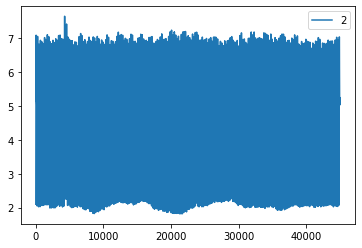

In [7]:
df.plot(y=2)

## 2. 前処理

今回学習させるのは、3列目である。

In [8]:
ecg = df.iloc[:,2].values
ecg = ecg.reshape(len(ecg), -1)

print("length of ECG data:", len(ecg))

length of ECG data: 45000


### データの前処理として、平均を0、分散を1に合わせる。

In [9]:
scaler = StandardScaler()
std_ecg = scaler.fit_transform(ecg)

### グラフの概形を確認する

<Figure size 432x288 with 0 Axes>

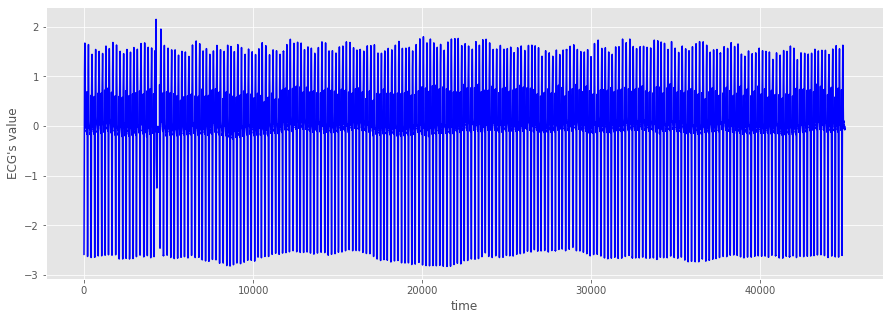

In [10]:
plt.figure()

plt.style.use('ggplot')
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('ECG\'s value')
plt.plot(np.arange(45000), std_ecg[:45000], color='b')

plt.show()

全体的に平坦であるが、time=5000ぐらいでグラフが崩れている。  
これを**異常と見倣して**、異常箇所を拡大表示してみる。

### 異常箇所の確認

<Figure size 432x288 with 0 Axes>

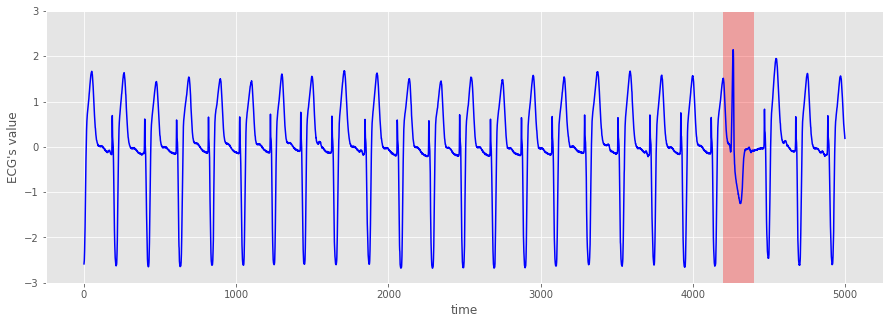

In [11]:
plt.figure()

plt.style.use('ggplot')
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('ECG\'s value')
plt.plot(np.arange(5000), std_ecg[:5000], color='b')
plt.ylim(-3, 3)

# 異常箇所の背景を塗りつぶす
x = np.arange(4200,4400)
y1 = [-3]*len(x)
y2 = [3]*len(x)
plt.fill_between(x, y1, y2, facecolor='r', alpha=0.3)

plt.show()

### 正常データの取り出し

正常データのみで学習するために、time >= 5000 のデータを取り出す

In [12]:
normal_cycle = std_ecg[5000:]

normal_cycle.shape

(40000, 1)

### 学習、検証データに分割

In [13]:
lookback = 10
batch_size = 100
pred_length = 3

def generator(data, min_index, max_index,lookback=10, delay=1, pred_length=3, shuffle=False, batch_size=100, step=1):
    """
    data: 分割するデータ
    """
    
    if max_index is None:
        max_index = len(data) - delay - pred_length - 1 
    i = min_index + lookback 

    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows), pred_length))

        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay : rows[j] + delay + pred_length].flatten()

        yield samples, targets
        
# 注) delayとstepは今回は用いない。それぞれ、「delay後のデータを予測する」、「stepおきにデータを使用する」という意味。

In [14]:
# 学習用データのジェネレータ
train_gen = generator(
    normal_cycle,
    min_index=0,
    max_index=20000,
    lookback=lookback,
    batch_size=batch_size
)


# 検証用のデータセット
val_gen = generator(
    normal_cycle,
    min_index=20001,
    max_index=30000,
    lookback=lookback
)

# 検証データセット全体を調べるためにval_genから抽出する時間刻みの数
val_steps = (30001 - 20001 -lookback) // batch_size

## 3. 学習

### モデルの構築

LSTMを2つ重ねたモデルとする。

In [15]:
def create_model(output_size=3):
    model = Sequential()
    
    model.add(layers.LSTM(35, return_sequences=True, input_shape=(None, normal_cycle.shape[-1])))
    model.add(layers.LSTM(35))
    model.add(layers.Dense(output_size))
    
    return model

In [16]:
model = create_model(pred_length)

2021-10-30 00:37:44.315520: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
model.compile(optimizer=rmsprop_v2.RMSprop(), loss="mse")

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 35)          5180      
_________________________________________________________________
lstm_1 (LSTM)                (None, 35)                9940      
_________________________________________________________________
dense (Dense)                (None, 3)                 108       
Total params: 15,228
Trainable params: 15,228
Non-trainable params: 0
_________________________________________________________________


### 学習を実行

In [19]:
train_result = model.fit_generator(
    train_gen,
    steps_per_epoch=200,
    epochs=50,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/50


/Users/kanade/develop/lstm-tutorial/.venv/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-10-30 00:37:44.746383: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


200/200 [==============================] - 5s 10ms/step - loss: 0.1971 - val_loss: 0.0546
Epoch 2/50
200/200 [==============================] - 2s 8ms/step - loss: 0.0496 - val_loss: 0.0335
Epoch 3/50
200/200 [==============================] - 2s 8ms/step - loss: 0.0290 - val_loss: 0.0183
Epoch 4/50
200/200 [==============================] - 1s 7ms/step - loss: 0.0208 - val_loss: 0.0209
Epoch 5/50
200/200 [==============================] - 2s 8ms/step - loss: 0.0172 - val_loss: 0.0156
Epoch 6/50
200/200 [==============================] - 2s 8ms/step - loss: 0.0150 - val_loss: 0.0160
Epoch 7/50
200/200 [==============================] - 2s 8ms/step - loss: 0.0130 - val_loss: 0.0120
Epoch 8/50
200/200 [==============================] - 2s 8ms/step - loss: 0.0117 - val_loss: 0.0121
Epoch 9/50
200/200 [==============================] - 1s 7ms/step - loss: 0.0105 - val_loss: 0.0115
Epoch 10/50
200/200 [==============================] - 2s 8ms/step - loss: 0.0097 - val_loss: 0.0096
Epoch 11/

### 学習と検証で損失の推移を可視化

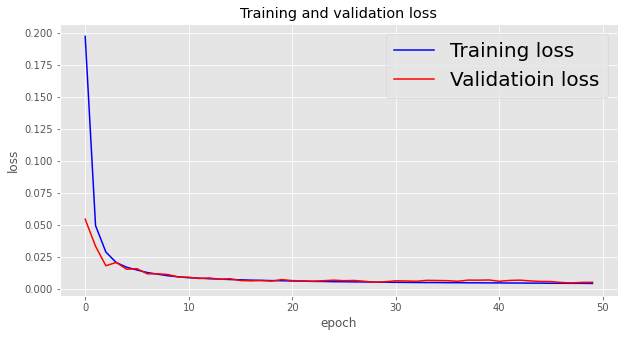

In [20]:
train_loss = train_result.history["loss"]
val_loss = train_result.history["val_loss"]

epochs = range(len(train_loss))

plt.figure(figsize=(10,5))

plt.plot(epochs, train_loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validatioin loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training and validation loss")
plt.legend(fontsize=20)

plt.show()

## 4. テスト

テストデータにおける予測値と目標値を用意する

In [21]:
# 予測用のデータセット
test_gen_pred = generator(
    normal_cycle,
    min_index=30001,
    max_index=None,
    lookback=lookback
)

test_steps = (len(normal_cycle) - 30001 - lookback) // batch_size

test_pred = model.predict_generator(test_gen_pred, steps=test_steps)

/Users/kanade/develop/lstm-tutorial/.venv/lib/python3.8/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [22]:
# 目標用のデータセット
test_gen_target = generator(
    normal_cycle, 
    min_index=30001,
    max_index=None,
    lookback=lookback,
)

test_target = np.zeros((test_steps * batch_size , pred_length))

for i in range(test_steps):
    test_target[i * batch_size: (i + 1) * batch_size] = next(test_gen_target)[1]

### 平均二乗誤差（MSE：Mean Squared Error）を求める

In [23]:
print(mean_squared_error(test_pred, test_target))

0.004424095265863259


### グラフで確認

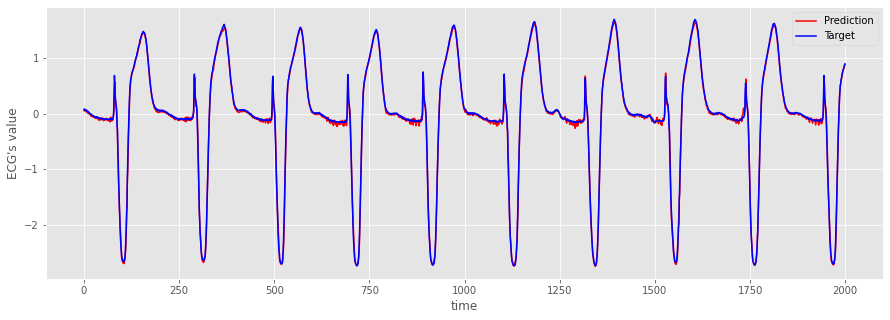

In [24]:
plt.figure(figsize=(15,5))

plt.plot(range(len(test_pred[0:2000, 0])), test_pred[0:2000, 0], "r", label="Prediction")
plt.plot(range(len(test_target[0:2000, 0])), test_target[0:2000, 0], "b", label="Target")
plt.xlabel("time")
plt.ylabel('ECG\'s value')
plt.legend(fontsize=10)

plt.show()

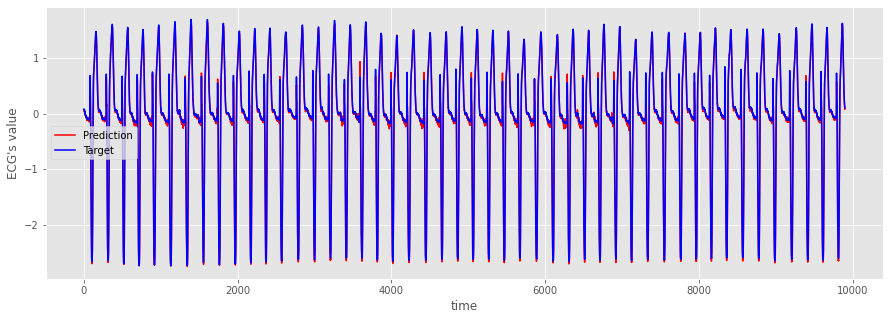

In [25]:
plt.figure(figsize=(15,5))

plt.plot(range(len(test_pred[:,0])), test_pred[:,0], "r", label="Prediction")
plt.plot(range(len(test_target[:,0])), test_target[:,0], "b", label="Target")
plt.xlabel("time")
plt.ylabel('ECG\'s value')
plt.legend(fontsize=10)

plt.show()

### 正規分布のフィッティング

In [26]:
# テストデータの誤差
error =  test_pred - test_target

# 平均
mean = np.mean(error, axis=0)
print("mean:\n {}\n".format(mean))

# 共分散 (cov)を求める
cov = np.cov(error, rowvar=False, bias=True)
print("cov:\n {}".format(cov))

mean:
 [-0.01880418 -0.01771117 -0.01640986]

cov:
 [[0.00182766 0.00206721 0.00175045]
 [0.00206721 0.00406418 0.00426843]
 [0.00175045 0.00426843 0.00644388]]


## 5. 異常の検出

### マハラノビス距離

マハラノビス距離はサンプリングデータが**平均値からどのくらい離れているか**を表す。  

In [27]:
def mahalanobis_dist(x, mean, cov):
    d = np.dot(x - mean, np.linalg.inv(cov))
    d = np.dot(d, (x - mean).T)
    
    return d

In [28]:
# 予測用
detection_gen_pred = generator(
    std_ecg, 
    min_index=0,
    max_index=5000,
    lookback=lookback,
)

detection_steps = (5000 -lookback) // batch_size

detection_pred = model.predict_generator(detection_gen_pred, steps=detection_steps)

/Users/kanade/develop/lstm-tutorial/.venv/lib/python3.8/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [29]:
# 目標用波形
detection_gen_target = generator(
    std_ecg, 
    min_index=0,
    max_index=5000,
    lookback=lookback,
)

detection_target = np.zeros((detection_steps * batch_size, pred_length))

for i in range(detection_steps):
    detection_target[i * batch_size:(i + 1) * batch_size] = next(detection_gen_target)[1]

誤差ベクトルを用いて、マハラノビス距離を求める

In [30]:
error_detection = detection_pred - detection_target 

m_dist = []

for e in error_detection:
    m_dist.append(mahalanobis_dist(e, mean, cov))

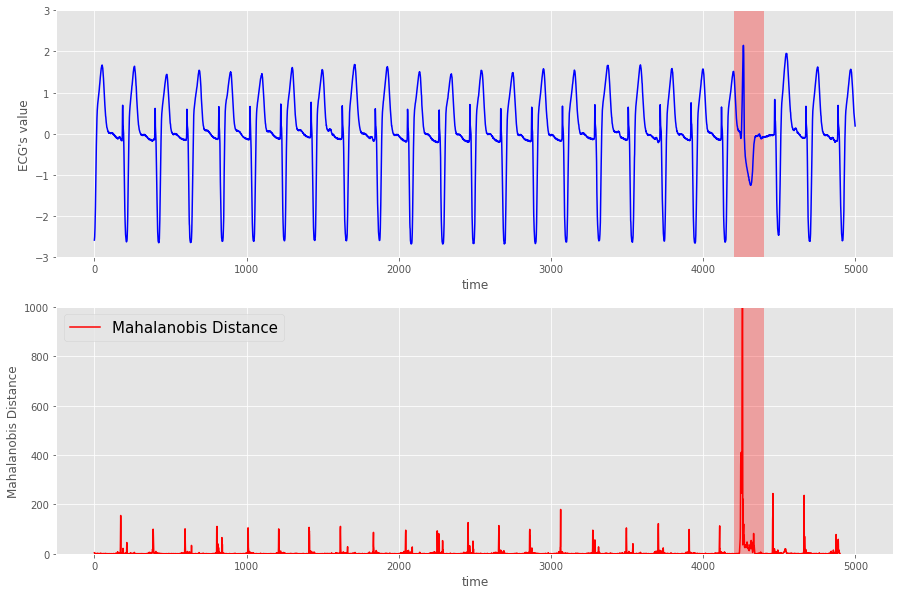

In [31]:
fig, axes = plt.subplots(nrows=2, figsize=(15,10))

axes[0].plot(std_ecg[:5000],color='b',label='original data')
axes[0].set_xlabel('time')
axes[0].set_ylabel('ECG\'s value' )
axes[0].set_xlim(-250, 5250)
axes[0].set_ylim(-3, 3)
x = np.arange(4200, 4400)
y1 = [-3] * len(x)
y2 = [3] * len(x)
axes[0].fill_between(x, y1, y2, facecolor='r', alpha=0.3)

axes[1].plot(m_dist, color='r',label='Mahalanobis Distance')
axes[1].set_xlabel('time')
axes[1].set_ylabel('Mahalanobis Distance')
axes[1].set_xlim(-250, 5250)
axes[1].set_ylim(0, 1000)
y1 = [0] * len(x)
y2 = [1000] * len(x)
axes[1].fill_between(x, y1, y2, facecolor='r', alpha=0.3)

plt.legend(fontsize=15)
plt.show()